# Fetch New Data

In [1]:
# Imports packages
import requests
import json
import pandas as pd
import numpy as np

In [2]:
# Creates list of series
Series = pd.read_excel("CPI_SERIES_IDS_US.xlsx")
names = Series[['ITEM_TITLE','LABSTAT_SERIESID']]
series = [x[0] for x in Series[['LABSTAT_SERIESID']].to_numpy().tolist()]

In [3]:
# Splits series into chunnked list, containing 50 elements
chunked_series = list()
chunk_size = 50        # BLS API only allows for 50 series to be pulled at a time
for i in range(0, len(series), chunk_size):
    chunked_series.append(series[i:i+chunk_size])
chunks = round(len(series)/chunk_size)
print("There are",chunks,"chunks in the series")

There are 8 chunks in the series


In [4]:
[chunk for chunk in range(int(chunks))]

[0, 1, 2, 3, 4, 5, 6, 7]

In [5]:
# Defines function to import CPI data from BLS
def importCPI(chunked_series,startyear,endyear):
    '''
    seriesid = list, series IDs
    startyear = string, year to start data, format is YYYY
    endyear = string, year to end data, format is YYYY
    '''

    # Pulls the data as json, stores in 'json_data'\    
    headers = {'Content-type': 'application/json'}
    data = {chunk: json.dumps({"seriesid": chunked_series[chunk],"startyear":startyear, "endyear":endyear, "registrationkey":"53a11636621548a3a6397ca1c6f3075d"}) for chunk in range(int(chunks))}
    p = {chunk: requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data[chunk], headers=headers) for chunk in range(int(chunks))}
    json_data = {chunk: json.loads(p[chunk].text) for chunk in range(int(chunks))}
    
    # Transfers each series' data into a dictionary, converts each into dataframe, and merges all into a single dataframe (set of years, all series)
    json_dict = {json_data[chunk]['Results']['series'][i]['seriesID']: json_data[chunk]['Results']['series'][i]['data'] for chunk in range(int(chunks)) for i in range(0,min(50,len(chunked_series[chunk])))}
    seriesids = [i for chunk in range(int(chunks)) for i in chunked_series[chunk]]
    series_dict = {seriesids[i]: pd.json_normalize(json_dict[seriesids[i]]) for i in range(0,len(seriesids))}
    for i in range(0,len(seriesids)):
        series_dict[seriesids[i]].rename(columns = {'value': seriesids[i]}, inplace=True)
    df1 = pd.concat([series_dict[seriesids[0]][['year','period','periodName']]])
    df2 = pd.concat([series_dict[seriesids[i]][seriesids[i]] for i in range(0,len(seriesids)) if series_dict[seriesids[i]].empty==False], axis=1)

    missing_seriesids = []
    for i in range(0,len(seriesids)):
        if series_dict[seriesids[i]].empty==True:
            missing_seriesids.append(seriesids[i])

    df2 = df2.reindex(columns = df2.columns.tolist() + missing_seriesids)

    df = pd.merge(df1, df2, how='inner', left_index=True, right_index=True)
    return df

In [6]:
# Imports data
current_year = 2022
years = np.arange(1950,current_year,10).astype(str).tolist()

data = {year: importCPI(chunked_series,year,str(int(year)+10)) for year in years} # BLS API only allows for 10 years to be pulled at a time

In [173]:
# data

In [121]:
# Concatenates into a single dataframe
df_cpi = pd.concat([data[x] for x in years])
df_cpi['monthNumber'] = df_cpi['period'].str.extract(r"(\d+)")
df_cpi = df_cpi.sort_values(by=['year','monthNumber'],axis=0)
df_cpi = df_cpi.reset_index(drop=True)
df_cpi = df_cpi[['year','period','periodName','monthNumber'] + series]
df_cpi['yearMonth'] = df_cpi['year'] + df_cpi['monthNumber']
df_cpi = df_cpi.drop_duplicates(subset=['yearMonth'])
df_cpi['date'] = pd.period_range(start='1/1950', periods=len(df_cpi), freq='M')
df_cpi = df_cpi.set_index('date')
df_cpi = df_cpi[series]

C:\Users\sroma\AppData\Local\Temp\ipykernel_29472\445369006.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpi['monthNumber'] = df_cpi['period'].str.extract(r"(\d+)")


In [122]:
df_cpi

,CUUR0000AA0,CUUR0000SA0,CUUR0000SA0E,CUUR0000SA0L1,CUUR0000SA0L12,CUUR0000SA0L12E,CUUR0000SA0L12E4,CUUR0000SA0L1E,CUUR0000SA0L2,CUUR0000SA0L5,...,CUUR0000SS62052,CUUR0000SS62053,CUUR0000SS62054,CUUR0000SS62055,CUUR0000SS68021,CUUR0000SS68023,CUUR0000SSEA011,CUUR0000SSFV031A,CUUR0000SSGE013,CUUR0000SSHJ031
date,,,,,,,,,,,,,,,,,,,,,
1950-01,70.5,23.5,NaN,23.5,NaN,NaN,NaN,NaN,25.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-02,70.3,23.5,NaN,23.5,NaN,NaN,NaN,NaN,25.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-03,70.6,23.6,NaN,23.5,NaN,NaN,NaN,NaN,25.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-04,70.7,23.6,NaN,23.5,NaN,NaN,NaN,NaN,25.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-05,71.0,23.7,NaN,23.5,NaN,NaN,NaN,NaN,25.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03,861.235,287.504,298.246,286.196,260.018,257.366,258.321,289.305,267.420,275.372,...,112.135,219.626,311.775,144.925,171.710,272.817,241.622,47.741,79.546,113.996
2022-04,866.042,289.109,298.469,287.595,261.255,258.776,260.020,290.846,268.974,276.967,...,112.067,223.311,314.416,145.983,175.257,279.941,242.478,47.935,79.955,112.704
2022-05,875.589,292.296,316.761,290.760,264.868,260.146,261.361,292.506,272.550,280.207,...,115.660,224.442,311.374,147.469,175.257,288.414,248.539,48.509,80.300,112.308


In [93]:
# Exports to Excel
# df_cpi.to_excel("Raw CPI Data (July 2022).xlsx")

In [ ]:
# Adds to SQL Database
# ...

# Load Existing Data

In [191]:
# Reads in data from Excel
df_cpi = pd.read_excel("Raw CPI Data (July 2022).xlsx")
df_cpi.drop('Unnamed: 0', inplace=True, axis=1)

In [94]:
# Displays first 10 rows and columns
df_cpi.iloc[:,:10]

,CUUR0000AA0,CUUR0000SA0,CUUR0000SA0E,CUUR0000SA0L1,CUUR0000SA0L12,CUUR0000SA0L12E,CUUR0000SA0L12E4,CUUR0000SA0L1E,CUUR0000SA0L2,CUUR0000SA0L5
date,,,,,,,,,,
1950-01,70.5,23.5,NaN,23.5,NaN,NaN,NaN,NaN,25.1,NaN
1950-02,70.3,23.5,NaN,23.5,NaN,NaN,NaN,NaN,25.1,NaN
1950-03,70.6,23.6,NaN,23.5,NaN,NaN,NaN,NaN,25.1,NaN
1950-04,70.7,23.6,NaN,23.5,NaN,NaN,NaN,NaN,25.1,NaN
1950-05,71.0,23.7,NaN,23.5,NaN,NaN,NaN,NaN,25.3,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-03,861.235,287.504,298.246,286.196,260.018,257.366,258.321,289.305,267.420,275.372
2022-04,866.042,289.109,298.469,287.595,261.255,258.776,260.020,290.846,268.974,276.967
2022-05,875.589,292.296,316.761,290.760,264.868,260.146,261.361,292.506,272.550,280.207


In [125]:
# Transforms data  into % change
df_cpi[series] = df_cpi[series].astype(float)
df_cpi[series] = df_cpi[series].pct_change(12)
df_cpi = df_cpi.iloc[12:,:]

In [152]:
# Creates boolean dataframe for whether series has > 2% inflation 
df_cpi["Above 2 %"] = df_cpi.gt(0.02).astype(int).sum(axis=1) / df_cpi.notna().astype(int).sum(axis=1)
df_cpi["above2"] = df_cpi.gt(0.02).astype(int).sum(axis=1)

C:\Users\sroma\AppData\Local\Temp\ipykernel_29472\1486074743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cpi["Above 2 %"] = df_cpi.gt(0.02).astype(int).sum(axis=1) / df_cpi.notna().astype(int).sum(axis=1)
C:\Users\sroma\AppData\Local\Temp\ipykernel_29472\1486074743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cpi["above2"] = df_cpi.gt(0.02).astype(int).sum(axis=1)


<AxesSubplot:xlabel='date'>

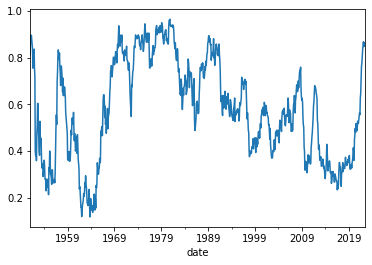

In [154]:
df_cpi["Above 2 %"].plot()

In [192]:
# Summary Stats

print("The latest CPI reading for July was","{:.1%}".format(df_cpi.iloc[-1,1]),"and the proportion of categories above 2% was","{:.1%}".format(df_cpi["Above 2 %"].iloc[-1]))
print("Historically since 1951, on average","{:.1%}".format(df_cpi["Above 2 %"].mean()),"categories have experienced inflation in excess of 2%, with a standard deviation of",
      "{:.1%}".format(df_cpi["Above 2 %"].std()),", so the current reading represents a",'\n',"{:.2f}".format(((df_cpi["Above 2 %"].iloc[-1] - df_cpi["Above 2 %"].mean()) / df_cpi["Above 2 %"].std())),
      "standard deviation difference.")

The latest CPI reading for July was 8.5% and the proportion of categories above 2% was 85.0%
Historically since 1951, on average 57.9% categories have experienced inflation in excess of 2%, with a standard deviation of 21.4% , so the current reading represents a 
 1.27 standard deviation difference.


In [ ]:
# ***** Next Steps ***** 


## Extra Code